In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import json
import sys

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, mean_squared_error, r2_score

from sklearn.model_selection import KFold, ShuffleSplit, RepeatedKFold, train_test_split, ParameterGrid
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import ElasticNetCV, ElasticNet

from joblib import dump, load

from permetrics.regression import RegressionMetric

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
proj_dir = Path('../..')

In [3]:
geopackage_fn = proj_dir / 'data/gis/geopackages/columbia_river_basin.gpkg'
# landsat_data_fn = proj_dir / 'Data/landsat/columbia_clean.csv'
landsat_data_fn = proj_dir / 'data/landsat/crb_landsat.csv'
insitu_data_dir = proj_dir / 'data/insitu/conditions/processed'
all_data_fn = proj_dir / 'methods/04-ml_development/input_data/ml_input_data_all.csv'

model_fn = proj_dir / 'methods/04-ml_development/var1/RFR1.joblib'

In [4]:
lsat_data = pd.read_csv(landsat_data_fn, parse_dates=['Date'])
all_data_ = pd.read_csv(all_data_fn, parse_dates=['Date'])

/var/folders/0q/tm370x9d1qdg6nt3w7pcqh_w0000gq/T/ipykernel_23605/494170857.py:2: DtypeWarning: Columns (5,17) have mixed types. Specify dtype option on import or set low_memory=False.
  all_data_ = pd.read_csv(all_data_fn, parse_dates=['Date'])


In [5]:

temp_locs_in_buffer = gpd.read_file(geopackage_fn, layer='TempLocationsInBuffer')

In [6]:
combined_insitu = pd.DataFrame()

for temp_loc in temp_locs_in_buffer.itertuples():
    insitu_fn = insitu_data_dir / f"{temp_loc.station_ID}.csv"
    if insitu_fn.exists():
        insitu_data = pd.read_csv(insitu_fn, parse_dates=['date'])
        # print(insitu_data.columns)
        # drop utc in date
        insitu_data['date'] = insitu_data['date'].dt.tz_localize(None)

        # keep date and average temperature
        # insitu_data = insitu_data[['date', 'avg_temp(C)', ]]
        # replace -999999 with nan
        # insitu_data.replace(-999999, np.nan, inplace=True)
        insitu_data.dropna(inplace=True)
        insitu_data['station_ID'] = temp_loc.station_ID
        insitu_data['RKm'] = temp_loc.RKm
        insitu_data['Name'] = temp_loc.reach_id
        insitu_data['GNIS_Name'] = temp_loc.GNIS_Name
        combined_insitu = pd.concat([combined_insitu, insitu_data])
        # break

# combined_insitu = pd.concat(combined_insitu)

combined_insitu.rename(columns={'date': 'Date'}, inplace=True)
# combined_insitu = combined_insitu.merge(lsat_data, on='Date', how='left')
# Data/insitu/conditions/processed
combined_insitu

,Date,outflow(m3/d),inflow(m3/d),spill(m3/d),avg_temp(C),wse(m),station_ID,RKm,Name,GNIS_Name,wse_tail(m),max_temp(C),min_temp(C),avg discharge (cfs)
1945,2004-04-29,4.932288e+07,6.923797e+07,0.0,11.89,626.245128,DART_ALF,140,Pend_Oreille_River_15,Pend Oreille River,NaN,NaN,NaN,NaN
1946,2004-04-30,4.991006e+07,6.654675e+07,0.0,11.84,626.318280,DART_ALF,140,Pend_Oreille_River_15,Pend Oreille River,NaN,NaN,NaN,NaN
1947,2004-05-01,4.937181e+07,5.945169e+07,0.0,12.29,626.354856,DART_ALF,140,Pend_Oreille_River_15,Pend Oreille River,NaN,NaN,NaN,NaN
1948,2004-05-02,4.856444e+07,6.067497e+07,0.0,12.26,626.364000,DART_ALF,140,Pend_Oreille_River_15,Pend Oreille River,NaN,NaN,NaN,NaN
1949,2004-05-03,5.531698e+07,8.563000e+07,0.0,12.92,626.382288,DART_ALF,140,Pend_Oreille_River_15,Pend Oreille River,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484,1998-09-11,NaN,NaN,NaN,20.80,NaN,USGS_460923123235800,60,Columbia_River_7,Columbia River,NaN,20.9,20.7,NaN
485,1998-09-12,NaN,NaN,NaN,20.80,NaN,USGS_460923123235800,60,Columbia_River_7,Columbia River,NaN,20.9,20.6,NaN
486,1998-09-13,NaN,NaN,NaN,20.60,NaN,USGS_460923123235800,60,Columbia_River_7,Columbia River,NaN,20.7,20.4,NaN
487,1998-09-14,NaN,NaN,NaN,20.50,NaN,USGS_460923123235800,60,Columbia_River_7,Columbia River,NaN,20.6,20.4,NaN


In [7]:
insitu_lsat = pd.merge(
    lsat_data, combined_insitu, on=["Date", "Name", "RKm"], how="outer"
)
insitu_lsat_clean = insitu_lsat[
    # (insitu_lsat['avg_temp(C)'] >=0) &
    (insitu_lsat["WaterTempC"] >= -40)
    & (insitu_lsat["WaterTempC"] <= 80)
    # & (insitu_lsat["avg_temp(C)"] <= 40)
].copy()
insitu_lsat_clean[["WidthMin", "WidthMean", "WidthMax"]] = insitu_lsat_clean[
    ["WidthMin", "WidthMean", "WidthMax"]
].fillna(15)

insitu_lsat_clean["DOY"] = insitu_lsat_clean["Date"].dt.dayofyear

# insitu_lsat_clean.to_csv('ml_inputs_data.csv', index=False)

In [8]:
col_data = insitu_lsat_clean[insitu_lsat_clean["Name"].str.startswith("Columbia")].dropna(subset=['LandTempC', 'NDVI']).copy()

In [9]:
rfr = load(model_fn)

In [10]:
features = [
    "NDVI",
    "LandTempC",
    "ClimateClass",
    "DOY",
    # "WidthMin",
    "WidthMean",
    # "WidthMax",
    # "WaterTempC",
]

In [11]:
col_data['pred_temp'] = rfr.predict(col_data[features]) 

In [12]:
# col_test_ltm = col_data.groupby('RKm')

# fig, ax = plt.subplots(figsize=(15, 4))
# col_test_ltm.plot(x='RKm', y='pred_temp', ax=ax, label='Predicted')
# col_test_ltm.plot.scatter(x='RKm', y='avg_temp(C)', ax=ax, )
# # col_test_ltm.plot(x='RKm', y='diff', ax=ax, label='Observed')

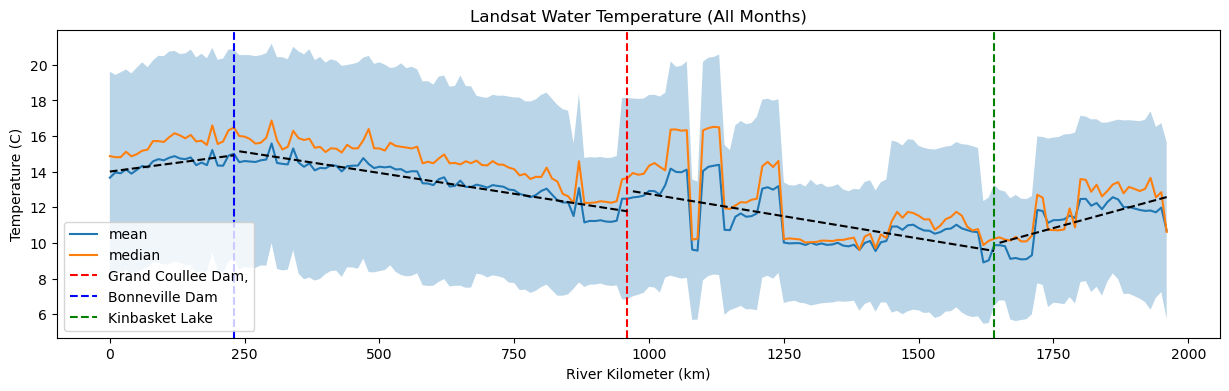

In [13]:
# group by RKm and calculate the mean, std, median, min, max of LandTempC, pred_temp, ClimateClass
# operation on summer months only
# co = columbia['Date'].dt.month.isin([6, 7, 8])
co = col_data['Date'].dt.month.isin([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
col_stats = col_data[co].groupby('RKm').agg({'LandTempC': ['mean', 'std', 'median', 'min', 'max'], 'pred_temp': ['mean', 'std', 'median', 'min', 'max'], 'ClimateClass': ['mean', 'std', 'median', 'min', 'max']})

fig, ax = plt.subplots(figsize=(15, 4))
col_stats['pred_temp'][['mean','median',]].plot(ax=ax)
ax.fill_between(col_stats.index, col_stats['pred_temp']['mean'] - col_stats['pred_temp']['std'], col_stats['pred_temp']['mean'] + col_stats['pred_temp']['std'], alpha=0.3)
ax.axvline(x=960, color='r', linestyle='--', label='Grand Coullee Dam,')
# ax.axvline(x=305, color='k', linestyle='--', label='Dalles Dam')
ax.axvline(x=230, color='b', linestyle='--', label='Bonneville Dam')
ax.axvline(x=1640, color='g', linestyle='--', label='Kinbasket Lake')
# ax.axvline(x=870, color='g', linestyle='--')
ax.legend(loc='lower left')
ax.set_xlabel('River Kilometer (km)')
ax.set_ylabel('Temperature (C)')

ax.set_title('Landsat Water Temperature (All Months)')

# find the line of bes fit and plot it
# lower columbia
x_lower = col_stats[col_stats.index <=230].index
y_lower = col_stats[col_stats.index <=230]['pred_temp']['mean']
m_lower, b_lower = np.polyfit(x_lower, y_lower, 1)
ax.plot(x_lower, m_lower*x_lower + b_lower, color='k', linestyle='--')

# mid columbia
x_middle = col_stats[(col_stats.index >230) & (col_stats.index <=960)].index
y_middle = col_stats[(col_stats.index >230) & (col_stats.index <=960)]['pred_temp']['mean']
m_mid, b_mid = np.polyfit(x_middle, y_middle, 1)
ax.plot(x_middle, m_mid*x_middle + b_mid, color='k', linestyle='--')

# upper columbia -1st part up to kinbasket lake
x_upper1 = col_stats[(col_stats.index >960) & (col_stats.index <=1640)].index
y_upper1 = col_stats[(col_stats.index >960) & (col_stats.index <=1640)]['pred_temp']['mean']
m_upper1, b_upper1 = np.polyfit(x_upper1, y_upper1, 1)
ax.plot(x_upper1, m_upper1*x_upper1 + b_upper1, color='k', linestyle='--')

# upper columbia -2nd part after kinbasket lake
x_upper2 = col_stats[col_stats.index >1640].index
y_upper2 = col_stats[col_stats.index >1640]['pred_temp']['mean']
m_upper2, b_upper2 = np.polyfit(x_upper2, y_upper2, 1)
ax.plot(x_upper2, m_upper2*x_upper2 + b_upper2, color='k', linestyle='--');



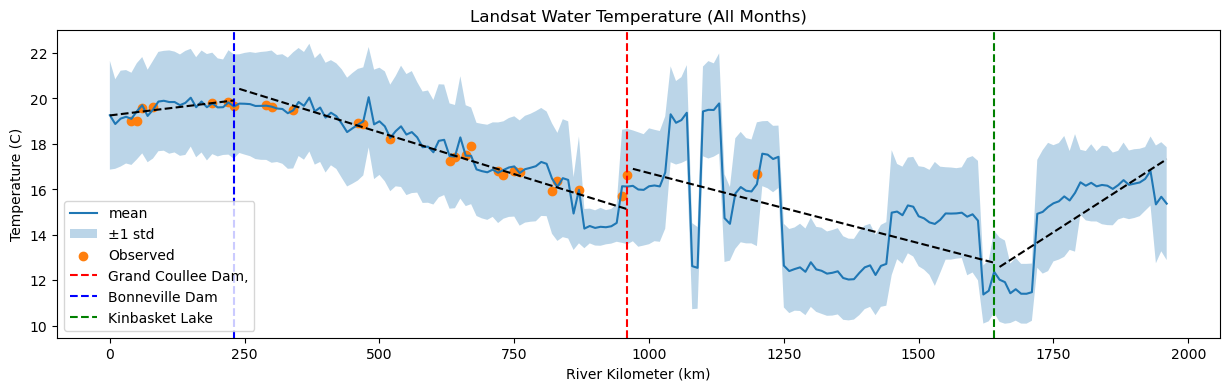

In [14]:
# group by RKm and calculate the mean, std, median, min, max of LandTempC, pred_temp, ClimateClass
# operation on summer months only
# co = columbia['Date'].dt.month.isin([6, 7, 8])
co = col_data["Date"].dt.month.isin(
    [  
        # 1,
        # 2,
        # 3,
        # 4,
        # 5,
        6,
        7,
        8,
        # 9,
        # 10,
        # 11,
        # 12
    ]
)
col_stats = (
    col_data[co]
    .groupby("RKm")
    .agg(
        {
            "avg_temp(C)": ["mean", "std", "median", "min", "max"],
            "pred_temp": ["mean", "std", "median", "min", "max"],
            "ClimateClass": ["mean", "std", "median", "min", "max"],
        }
    )
)

fig, ax = plt.subplots(figsize=(15, 4))
col_stats["pred_temp"][
    [
        "mean",
        # "median",
    ]
].plot(ax=ax, label="Estimated")
ax.fill_between(
    col_stats.index,
    col_stats["pred_temp"]["mean"] - col_stats["pred_temp"]["std"],
    col_stats["pred_temp"]["mean"] + col_stats["pred_temp"]["std"],
    alpha=0.3, label="±1 std",
)
ax.scatter(col_stats.index, col_stats["avg_temp(C)"]["mean"], label="Observed")
ax.axvline(x=960, color="r", linestyle="--", label="Grand Coullee Dam,")
# ax.axvline(x=305, color='k', linestyle='--', label='Dalles Dam')
ax.axvline(x=230, color="b", linestyle="--", label="Bonneville Dam")
ax.axvline(x=1640, color="g", linestyle="--", label="Kinbasket Lake")
# ax.axvline(x=870, color='g', linestyle='--')
ax.legend(loc="lower left")
ax.set_xlabel("River Kilometer (km)")
ax.set_ylabel("Temperature (C)")

ax.set_title("Landsat Water Temperature (All Months)")

# find the line of bes fit and plot it
# lower columbia
x_lower = col_stats[col_stats.index <= 230].index
y_lower = col_stats[col_stats.index <= 230]["pred_temp"]["mean"]
m_lower, b_lower = np.polyfit(x_lower, y_lower, 1)
ax.plot(x_lower, m_lower * x_lower + b_lower, color="k", linestyle="--")


# mid columbia
x_middle = col_stats[(col_stats.index > 230) & (col_stats.index <= 960)].index
y_middle = col_stats[(col_stats.index > 230) & (col_stats.index <= 960)]["pred_temp"][
    "mean"
]
m_mid, b_mid = np.polyfit(x_middle, y_middle, 1)
ax.plot(x_middle, m_mid * x_middle + b_mid, color="k", linestyle="--")

# upper columbia -1st part up to kinbasket lake
x_upper1 = col_stats[(col_stats.index > 960) & (col_stats.index <= 1640)].index
y_upper1 = col_stats[(col_stats.index > 960) & (col_stats.index <= 1640)]["pred_temp"][
    "mean"
]
m_upper1, b_upper1 = np.polyfit(x_upper1, y_upper1, 1)
ax.plot(x_upper1, m_upper1 * x_upper1 + b_upper1, color="k", linestyle="--")

# upper columbia -2nd part after kinbasket lake
x_upper2 = col_stats[col_stats.index > 1640].index
y_upper2 = col_stats[col_stats.index > 1640]["pred_temp"]["mean"]
m_upper2, b_upper2 = np.polyfit(x_upper2, y_upper2, 1)
ax.plot(x_upper2, m_upper2 * x_upper2 + b_upper2, color="k", linestyle="--")

Season: spring
Lower Columbia Slope: -0.0008688446554697832
Middle Columbia Slope: -0.002250448191150645
Upper Columbia Slope: -0.002259293345525753 0.010589858447580336
Season: summer
Lower Columbia Slope: 0.0028621190878579637
Middle Columbia Slope: -0.007357500400488741
Upper Columbia Slope: -0.006165275288271187 0.015288874878166289
Season: fall
Lower Columbia Slope: 0.00398239174271559
Middle Columbia Slope: -0.005040558759104783
Upper Columbia Slope: -0.007619480521121984 0.0017065232336189997
Season: winter
Lower Columbia Slope: -0.003509468698501353
Middle Columbia Slope: -1.3752840081032875e-05
Upper Columbia Slope: -0.002774405042108742 -0.0036339623951525363


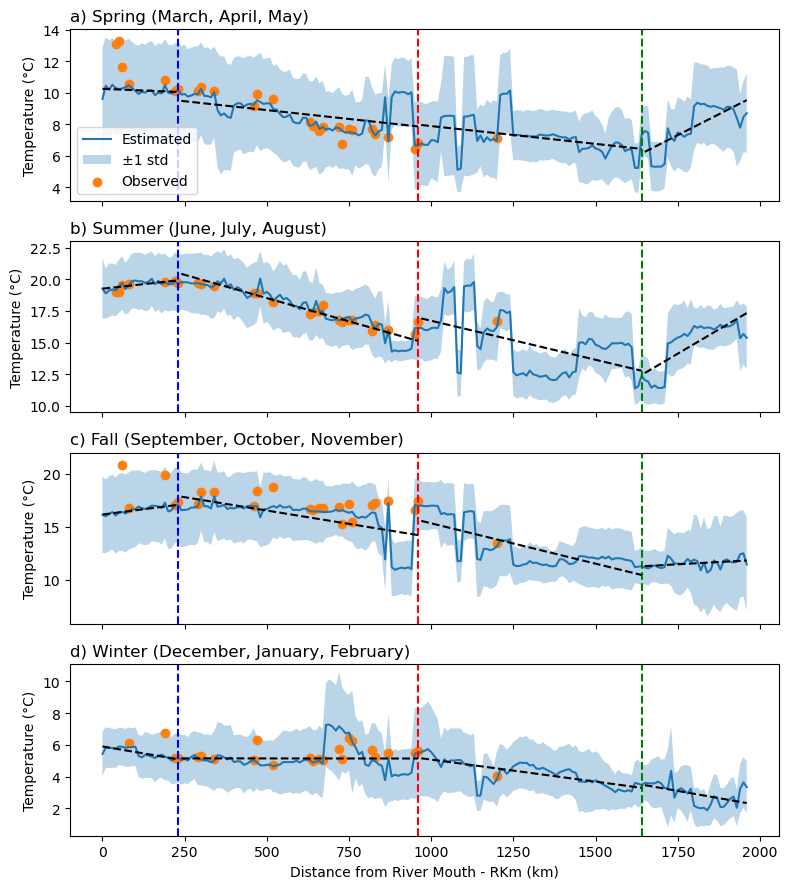

In [15]:
seasons = {
    "spring": [3, 4, 5],
    "summer": [6, 7, 8],
    "fall": [9, 10, 11],
    "winter": [12, 1, 2],
}

fig, ax = plt.subplots(4, 1, figsize=(8, 9), sharex=True)

season_ax = {
    "spring": ax[0],
    "summer": ax[1],
    "fall": ax[2],
    "winter": ax[3],
}

season_titles = {
    # "spring": "a) Spring (March, April, May)",
    # "summer": "b) Summer (June, July, August)",
    # "fall": "c) Fall (September, October, November)",
    # "winter": "d) Winter (December, January, February)",
    "spring": "a) Spring (March, April, May)",
    "summer": "b) Summer (June, July, August)",
    "fall": "c) Fall (September, October, November)",
    "winter": "d) Winter (December, January, February)",
}

for season, months in seasons.items():
    co = col_data["Date"].dt.month.isin(months)
    col_stats = (
        col_data[co]
        .groupby("RKm")
        .agg(
            {
                "avg_temp(C)": ["mean", "std", "median", "min", "max"],
                "pred_temp": ["mean", "std", "median", "min", "max"],
                "ClimateClass": ["mean", "std", "median", "min", "max"],
            }
        )
    )

    # col_stats["pred_temp"][
    #     [
    #         "mean",
    #         # "median",
    #     ]
    # ].plot(ax=season_ax[season], label="Estimated")
    season_ax[season].plot(
        col_stats.index,
        col_stats["pred_temp"]["mean"],
        label="Estimated",
    )
    season_ax[season].fill_between(
        col_stats.index,
        col_stats["pred_temp"]["mean"] - col_stats["pred_temp"]["std"],
        col_stats["pred_temp"]["mean"] + col_stats["pred_temp"]["std"],
        alpha=0.3,
        label="±1 std",
    )
    season_ax[season].scatter(
        col_stats.index, col_stats["avg_temp(C)"]["mean"], label="Observed"
    )
    season_ax[season].axvline(x=960, color="r", linestyle="--", 
                            #   label="Grand Coullee Dam,"
                              )
    season_ax[season].axvline(x=230, color="b", linestyle="--", 
                              #label="Bonneville Dam"
                              )
    season_ax[season].axvline(x=1640, color="g", linestyle="--",
                               #label="Kinbasket Lake"
                               )
    # season_ax[season].legend(loc="lower left")
    # season_ax[season].set_xlabel("River Kilometer (km)")
    season_ax[season].set_ylabel("Temperature (°C)")

    season_ax[season].set_title(season_titles[season], loc="left")

    # find the line of bes fit and plot it
    # lower columbia
    x_lower = col_stats[col_stats.index <= 230].index
    y_lower = col_stats[col_stats.index <= 230]["pred_temp"]["mean"]
    m_lower, b_lower = np.polyfit(x_lower, y_lower, 1)
    season_ax[season].plot(
        x_lower, m_lower * x_lower + b_lower, color="k", linestyle="--"
    )

    # mid columbia
    x_middle = col_stats[(col_stats.index > 230
                            ) & (col_stats.index <= 960)].index
    y_middle = col_stats[(col_stats.index > 230) & (col_stats.index <= 960)][
        "pred_temp"
    ]["mean"]
    m_mid, b_mid = np.polyfit(x_middle, y_middle, 1)
    season_ax[season].plot(
        x_middle, m_mid * x_middle + b_mid, color="k", linestyle="--"
    )

    # upper columbia -1st part up to kinbasket lake
    x_upper1 = col_stats[(col_stats.index > 960
                            ) & (col_stats.index <= 1640)].index
    y_upper1 = col_stats[(col_stats.index > 960) & (col_stats.index <= 1640)][
        "pred_temp"
    ]["mean"]
    m_upper1, b_upper1 = np.polyfit(x_upper1, y_upper1, 1)
    season_ax[season].plot(
        x_upper1, m_upper1 * x_upper1 + b_upper1, color="k", linestyle="--"
    )

    # upper columbia -2nd part after kinbasket lake
    x_upper2 = col_stats[col_stats.index > 1640].index
    y_upper2 = col_stats[col_stats.index > 1640]["pred_temp"]["mean"]
    m_upper2, b_upper2 = np.polyfit(x_upper2, y_upper2, 1)
    season_ax[season].plot(
        x_upper2, m_upper2 * x_upper2 + b_upper2, color="k", linestyle="--"
    )

    print("Season:", season)
    print("Lower Columbia Slope:", m_lower)
    print("Middle Columbia Slope:", m_mid)
    print("Upper Columbia Slope:", m_upper1, m_upper2)

season_ax["winter"].set_xlabel("Distance from River Mouth - RKm (km)")
season_ax["spring"].legend()
fig.tight_layout()
fig.savefig("columbia_temp_estimation.png", dpi=300)

Season: spring
Lower Columbia Slope: -0.09
Middle Columbia Slope: -0.23
Upper Columbia Slope: -0.23, 1.06
Season: summer
Lower Columbia Slope: 0.29
Middle Columbia Slope: -0.74
Upper Columbia Slope: -0.62, 1.53
Season: fall
Lower Columbia Slope: 0.40
Middle Columbia Slope: -0.50
Upper Columbia Slope: -0.76, 0.17
Season: winter
Lower Columbia Slope: -0.35
Middle Columbia Slope: -0.00
Upper Columbia Slope: -0.28, -0.36


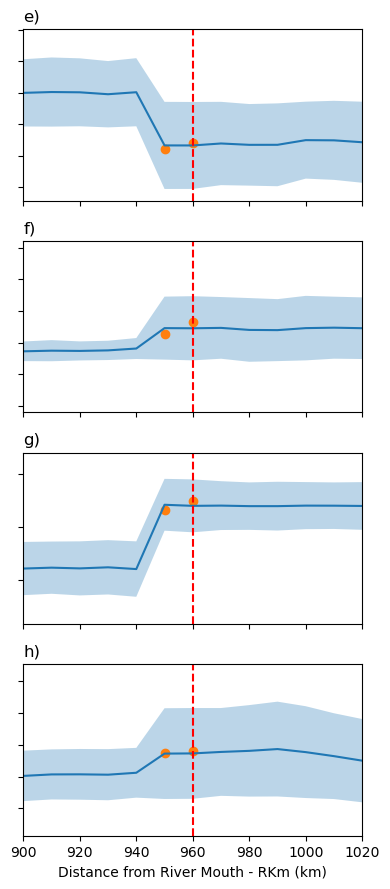

In [16]:
seasons = {
    "spring": [3, 4, 5],
    "summer": [6, 7, 8],
    "fall": [9, 10, 11],
    "winter": [12, 1, 2],
}

fig, ax = plt.subplots(4, 1, figsize=(4, 9), sharex=True)

season_ax = {
    "spring": ax[0],
    "summer": ax[1],
    "fall": ax[2],
    "winter": ax[3],
}

season_titles = {
    # "spring": "a) Spring (March, April, May)",
    # "summer": "b) Summer (June, July, August)",
    # "fall": "c) Fall (September, October, November)",
    # "winter": "d) Winter (December, January, February)",
    "spring": "e)", # Spring (March, April, May)",
    "summer": "f)", # Summer (June, July, August)",
    "fall": "g)", # Fall (September, October, November)",
    "winter": "h)", # Winter (December, January, February)",
}

for season, months in seasons.items():
    co = col_data["Date"].dt.month.isin(months)
    col_stats = (
        col_data[co]
        .groupby("RKm")
        .agg(
            {
                "avg_temp(C)": ["mean", "std", "median", "min", "max"],
                "pred_temp": ["mean", "std", "median", "min", "max"],
                "ClimateClass": ["mean", "std", "median", "min", "max"],
            }
        )
    )

    # col_stats["pred_temp"][
    #     [
    #         "mean",
    #         # "median",
    #     ]
    # ].plot(ax=season_ax[season], label="Estimated")
    season_ax[season].plot(
        col_stats.index,
        col_stats["pred_temp"]["mean"],
        label="Estimated",
    )
    season_ax[season].fill_between(
        col_stats.index,
        col_stats["pred_temp"]["mean"] - col_stats["pred_temp"]["std"],
        col_stats["pred_temp"]["mean"] + col_stats["pred_temp"]["std"],
        alpha=0.3,
        label="±1 std",
    )
    season_ax[season].scatter(
        col_stats.index, col_stats["avg_temp(C)"]["mean"], label="Observed"
    )
    season_ax[season].axvline(x=960, color="r", linestyle="--", label="Grand Coullee Dam,")
    season_ax[season].axvline(x=230, color="b", linestyle="--", label="Bonneville Dam")
    season_ax[season].axvline(x=1640, color="g", linestyle="--", label="Kinbasket Lake")
    # season_ax[season].legend(loc="lower left")
    # season_ax[season].set_xlabel("River Kilometer (km)")
    # season_ax[season].set_ylabel("Temperature (C)")
    # turn_off_the_y_labels
    season_ax[season].set_yticklabels([])

    season_ax[season].set_title(season_titles[season], loc="left")

    # find the line of bes fit and plot it
    # lower columbia
    x_lower = col_stats[col_stats.index <= 230].index
    y_lower = col_stats[col_stats.index <= 230]["pred_temp"]["mean"]
    m_lower, b_lower = np.polyfit(x_lower, y_lower, 1)
    # season_ax[season].plot(
    #     x_lower, m_lower * x_lower + b_lower, color="k", linestyle="--"
    # )

    # mid columbia
    x_middle = col_stats[(col_stats.index > 230
                            ) & (col_stats.index <= 960)].index
    y_middle = col_stats[(col_stats.index > 230) & (col_stats.index <= 960)][
        "pred_temp"
    ]["mean"]
    m_mid, b_mid = np.polyfit(x_middle, y_middle, 1)
    # season_ax[season].plot(
    #     x_middle, m_mid * x_middle + b_mid, color="k", linestyle="--"
    # )

    # upper columbia -1st part up to kinbasket lake
    x_upper1 = col_stats[(col_stats.index > 960
                            ) & (col_stats.index <= 1640)].index
    y_upper1 = col_stats[(col_stats.index > 960) & (col_stats.index <= 1640)][
        "pred_temp"
    ]["mean"]
    m_upper1, b_upper1 = np.polyfit(x_upper1, y_upper1, 1)
    # season_ax[season].plot(
    #     x_upper1, m_upper1 * x_upper1 + b_upper1, color="k", linestyle="--"
    # )

    # upper columbia -2nd part after kinbasket lake
    x_upper2 = col_stats[col_stats.index > 1640].index
    y_upper2 = col_stats[col_stats.index > 1640]["pred_temp"]["mean"]
    m_upper2, b_upper2 = np.polyfit(x_upper2, y_upper2, 1)
    # season_ax[season].plot(
    #     x_upper2, m_upper2 * x_upper2 + b_upper2, color="k", linestyle="--"
    # )

    season_ax[season].set_xlim(900, 1020)

    print("Season:", season)
    print(f"Lower Columbia Slope: {m_lower*1e2:.2f}", )
    print(f"Middle Columbia Slope: {m_mid*1e2:.2f}")
    print(f"Upper Columbia Slope: {m_upper1*1e2:.2f}, {m_upper2*1e2:.2f}")

season_ax["winter"].set_xlabel("Distance from River Mouth - RKm (km)")
fig.tight_layout()
fig.savefig("columbia_temp_estimation_zoomed.png", dpi=300)

Season: spring
Lower Columbia Slope: -0.0008688446554697832
Middle Columbia Slope: -0.002250448191150645
Upper Columbia Slope: -0.002259293345525753 0.010589858447580336
Season: summer
Lower Columbia Slope: 0.0028621190878579637
Middle Columbia Slope: -0.007357500400488741
Upper Columbia Slope: -0.006165275288271187 0.015288874878166289
Season: fall
Lower Columbia Slope: 0.00398239174271559
Middle Columbia Slope: -0.005040558759104783
Upper Columbia Slope: -0.007619480521121984 0.0017065232336189997
Season: winter
Lower Columbia Slope: -0.003509468698501353
Middle Columbia Slope: -1.3752840081032875e-05
Upper Columbia Slope: -0.002774405042108742 -0.0036339623951525363


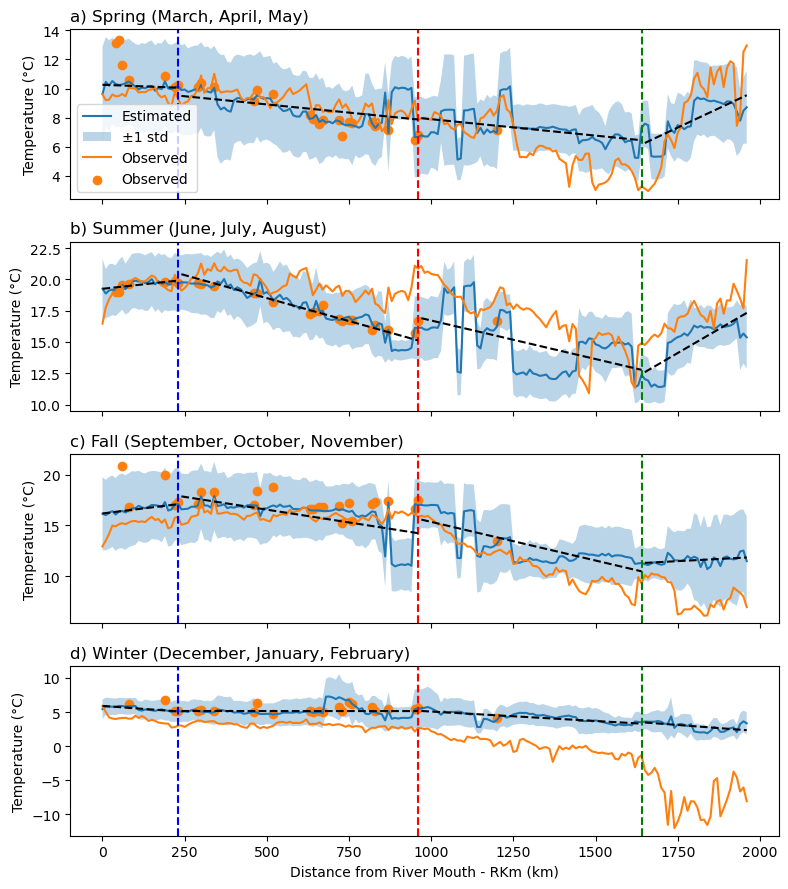

In [17]:
seasons = {
    "spring": [3, 4, 5],
    "summer": [6, 7, 8],
    "fall": [9, 10, 11],
    "winter": [12, 1, 2],
}

fig, ax = plt.subplots(4, 1, figsize=(8, 9), sharex=True)

season_ax = {
    "spring": ax[0],
    "summer": ax[1],
    "fall": ax[2],
    "winter": ax[3],
}

season_titles = {
    # "spring": "a) Spring (March, April, May)",
    # "summer": "b) Summer (June, July, August)",
    # "fall": "c) Fall (September, October, November)",
    # "winter": "d) Winter (December, January, February)",
    "spring": "a) Spring (March, April, May)",
    "summer": "b) Summer (June, July, August)",
    "fall": "c) Fall (September, October, November)",
    "winter": "d) Winter (December, January, February)",
}

for season, months in seasons.items():
    co = col_data["Date"].dt.month.isin(months)
    col_stats = (
        col_data[co]
        .groupby("RKm")
        .agg(
            {
                "avg_temp(C)": ["mean", "std", "median", "min", "max"],
                "pred_temp": ["mean", "std", "median", "min", "max"],
                "WaterTempC": ["mean", "std", "median", "min", "max"],
            }
        )
    )

    # col_stats["pred_temp"][
    #     [
    #         "mean",
    #         # "median",
    #     ]
    # ].plot(ax=season_ax[season], label="Estimated")
    season_ax[season].plot(
        col_stats.index,
        col_stats["pred_temp"]["mean"],
        label="Estimated",
    )
    season_ax[season].fill_between(
        col_stats.index,
        col_stats["pred_temp"]["mean"] - col_stats["pred_temp"]["std"],
        col_stats["pred_temp"]["mean"] + col_stats["pred_temp"]["std"],
        alpha=0.3,
        label="±1 std",
    )
    season_ax[season].plot(
        col_stats.index, col_stats["WaterTempC"]["mean"], label="Observed"
    )
    season_ax[season].scatter(
        col_stats.index, col_stats["avg_temp(C)"]["mean"], label="Observed"
    )
    season_ax[season].axvline(x=960, color="r", linestyle="--", 
                            #   label="Grand Coullee Dam,"
                              )
    season_ax[season].axvline(x=230, color="b", linestyle="--", 
                              #label="Bonneville Dam"
                              )
    season_ax[season].axvline(x=1640, color="g", linestyle="--",
                               #label="Kinbasket Lake"
                               )
    # season_ax[season].legend(loc="lower left")
    # season_ax[season].set_xlabel("River Kilometer (km)")
    season_ax[season].set_ylabel("Temperature (°C)")

    season_ax[season].set_title(season_titles[season], loc="left")

    # find the line of bes fit and plot it
    # lower columbia
    x_lower = col_stats[col_stats.index <= 230].index
    y_lower = col_stats[col_stats.index <= 230]["pred_temp"]["mean"]
    m_lower, b_lower = np.polyfit(x_lower, y_lower, 1)
    season_ax[season].plot(
        x_lower, m_lower * x_lower + b_lower, color="k", linestyle="--"
    )

    # mid columbia
    x_middle = col_stats[(col_stats.index > 230
                            ) & (col_stats.index <= 960)].index
    y_middle = col_stats[(col_stats.index > 230) & (col_stats.index <= 960)][
        "pred_temp"
    ]["mean"]
    m_mid, b_mid = np.polyfit(x_middle, y_middle, 1)
    season_ax[season].plot(
        x_middle, m_mid * x_middle + b_mid, color="k", linestyle="--"
    )

    # upper columbia -1st part up to kinbasket lake
    x_upper1 = col_stats[(col_stats.index > 960
                            ) & (col_stats.index <= 1640)].index
    y_upper1 = col_stats[(col_stats.index > 960) & (col_stats.index <= 1640)][
        "pred_temp"
    ]["mean"]
    m_upper1, b_upper1 = np.polyfit(x_upper1, y_upper1, 1)
    season_ax[season].plot(
        x_upper1, m_upper1 * x_upper1 + b_upper1, color="k", linestyle="--"
    )

    # upper columbia -2nd part after kinbasket lake
    x_upper2 = col_stats[col_stats.index > 1640].index
    y_upper2 = col_stats[col_stats.index > 1640]["pred_temp"]["mean"]
    m_upper2, b_upper2 = np.polyfit(x_upper2, y_upper2, 1)
    season_ax[season].plot(
        x_upper2, m_upper2 * x_upper2 + b_upper2, color="k", linestyle="--"
    )

    print("Season:", season)
    print("Lower Columbia Slope:", m_lower)
    print("Middle Columbia Slope:", m_mid)
    print("Upper Columbia Slope:", m_upper1, m_upper2)

season_ax["winter"].set_xlabel("Distance from River Mouth - RKm (km)")
season_ax["spring"].legend()
fig.tight_layout()

# Reconstruction all


In [18]:
all_data = all_data_.copy()

In [19]:
all_data_[all_data_['Mission']=='L5']['Name'].unique()

array(['Akolkolex_River_1', 'Akolkolex_River_2', 'Akolkolex_River_3', ...,
       'Youngs_River_3', 'Youngs_River_4', 'Youngs_River_5'], dtype=object)

In [20]:
all_data = all_data[['Date', 'Name','RKm', 'LandTempC', 'DOY', 'NDVI', 'WaterTempC', 'ClimateClass', 'WidthMean', 'avg_temp(C)']].copy()
all_data = all_data.dropna(subset=['LandTempC', 'NDVI'])
all_data = all_data[(all_data['WaterTempC']) >= -40 & (all_data['WaterTempC'] <= 80)].copy()
all_data['pred_temp'] = rfr.predict(all_data[features])

In [21]:
all_data.sort_values(['Name', 'RKm', 'Date'], inplace=True)

In [22]:
test_reaches = {
    1: "Columbia_River_96",
    2: "Kootenay_River_35",
    3: "Okanogan_River_13",
    4: "Willamette_River_20",
}

insitu_fp = {
    1: proj_dir / 'Data/insitu/conditions/processed/USBR_GCGW.csv',
    2: proj_dir / 'Data/insitu/conditions/processed/USGS_12301933.csv',
    3: proj_dir / 'Data/insitu/conditions/processed/USGS_12439500.csv',
    4: proj_dir / 'Data/insitu/conditions/processed/USGS_14174000.csv',
}

In [23]:
Columbia_River_96_insitu = pd.read_csv(insitu_fp[1], parse_dates=['date'])

In [24]:
# replace negative avg_temp(C) with nan
Columbia_River_96_insitu['avg_temp(C)'] = Columbia_River_96_insitu['avg_temp(C)'].apply(lambda x: np.nan if x < 0 else x)
Columbia_River_96_insitu.to_csv(insitu_fp[1], index=False)

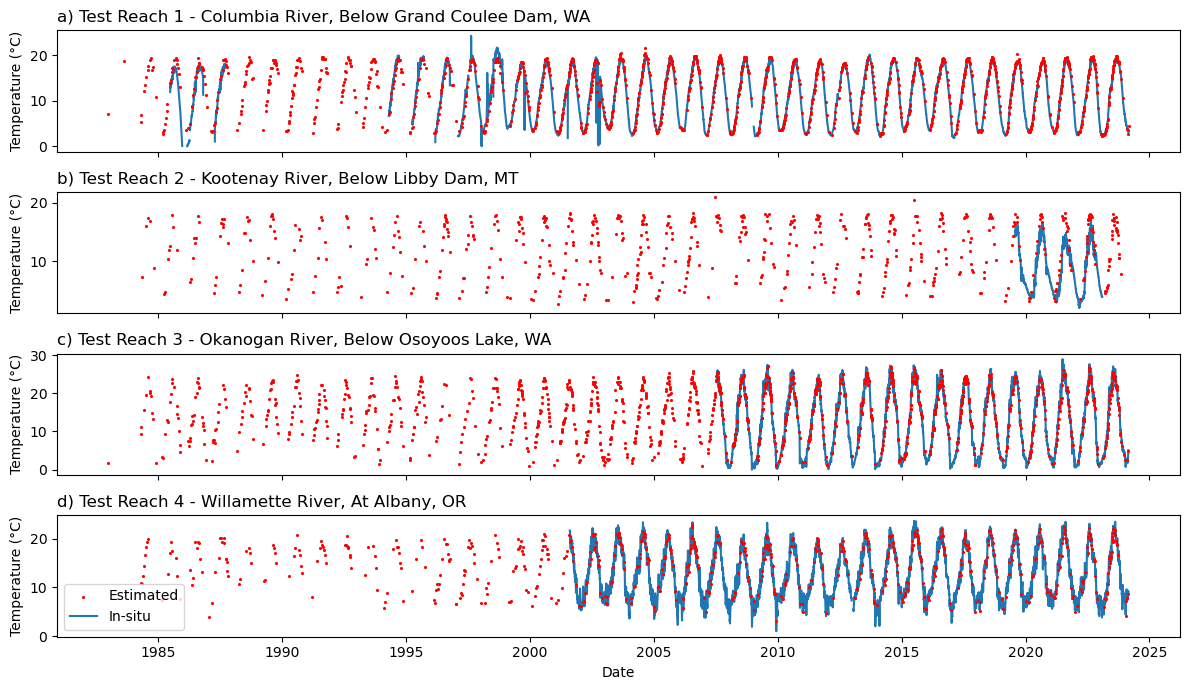

In [25]:
fig, axs = plt.subplots(4, 1, figsize=(12, 7), sharex=True)

for i, name in test_reaches.items():
    pred_temp = all_data[all_data['Name'] == name]
    obs_temp = pd.read_csv(insitu_fp[i], parse_dates=['date'])
    obs_temp['date'] = obs_temp['date'].dt.tz_localize(None)
    obs_temp = obs_temp[['date', 'avg_temp(C)']]

    ax = axs[i-1]
    ax.scatter(pred_temp['Date'], pred_temp['pred_temp'], label='Estimated', s=1.5, color='r', zorder=2)
    ax.plot(obs_temp['date'], obs_temp['avg_temp(C)'], label='In-situ', zorder=1)

    # ax.set_title(name)

    # ax.set_xlim(pd.Timestamp('1998-01-01'), pd.Timestamp('1998-12-31'))

# add titles
axs[0].set_title("a) Test Reach 1 - Columbia River, Below Grand Coulee Dam, WA", loc=  'left')
axs[1].set_title("b) Test Reach 2 - Kootenay River, Below Libby Dam, MT", loc='left')
axs[2].set_title("c) Test Reach 3 - Okanogan River, Below Osoyoos Lake, WA", loc='left')
axs[3].set_title("d) Test Reach 4 - Willamette River, At Albany, OR", loc= 'left')

# add y labels
axs[0].set_ylabel("Temperature (°C)")
axs[1].set_ylabel("Temperature (°C)")
axs[2].set_ylabel("Temperature (°C)")
axs[3].set_ylabel("Temperature (°C)")

axs[3].set_xlabel("Date")
axs[3].legend(loc='lower left') 

fig.tight_layout()
fig.savefig('test_reaches.png', dpi=300)

In [26]:
Snake_River_128 = all_data[all_data['Name'] == 'Snake_River_128']

# create a daily daterange for the entire period
date_range = pd.date_range(start=Snake_River_128['Date'].min(), end=Snake_River_128['Date'].max(), freq='D')

# create a dataframe with the date range
Snake_River_128_daily = pd.DataFrame(date_range, columns=['Date'])

# merge the daily date range with the Snake River 128 data
Snake_River_128_daily = pd.merge(Snake_River_128_daily, Snake_River_128[['Date', 'pred_temp']], on='Date', how='left')



<Axes: xlabel='Date', ylabel='pred_temp'>

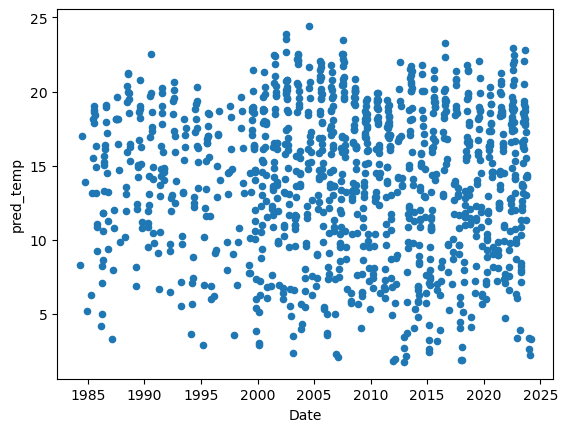

In [27]:
Snake_River_128_daily.plot.scatter(x='Date', y='pred_temp')

<Axes: xlabel='Date'>

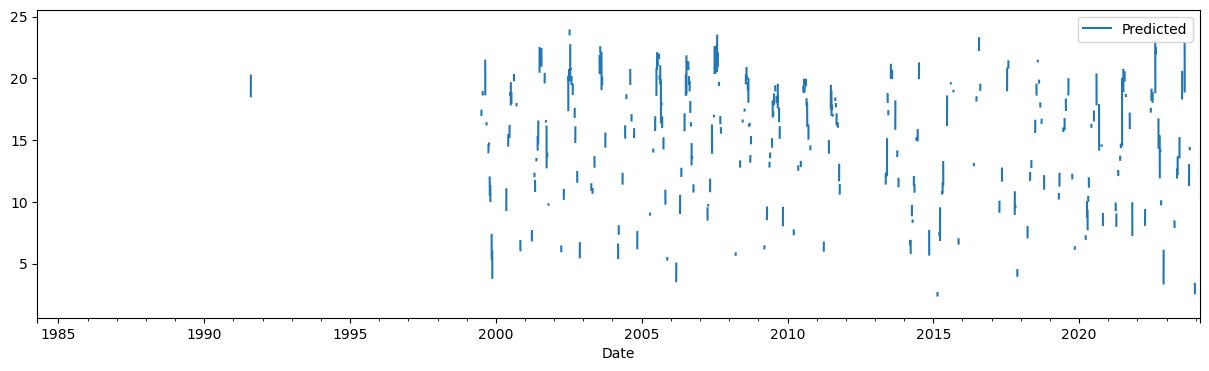

In [28]:
fig, ax = plt.subplots(figsize=(15, 4))
Snake_River_128_daily.plot(x='Date', y='pred_temp', ax=ax, label='Predicted')

In [29]:
all_data['Date'] = pd.to_datetime(all_data['Date'])

<Axes: xlabel='Date'>

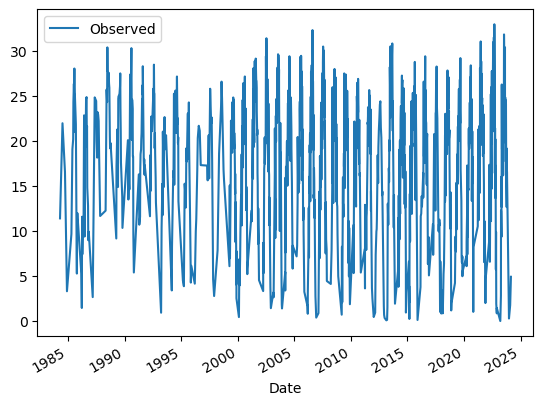

In [30]:
all_data[all_data['Name'] == 'Snake_River_128'].drop('avg_temp(C)', axis=1).plot(x='Date', y='WaterTempC', label='Observed',)

/var/folders/0q/tm370x9d1qdg6nt3w7pcqh_w0000gq/T/ipykernel_23605/619028442.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  all_data[all_data['Name'] == 'Snake_River_128'].resample('D', on='Date').mean().reset_index().plot(x='Date', y='pred_temp', ax=ax, label='Estimated', #s=1


<Axes: xlabel='Date'>

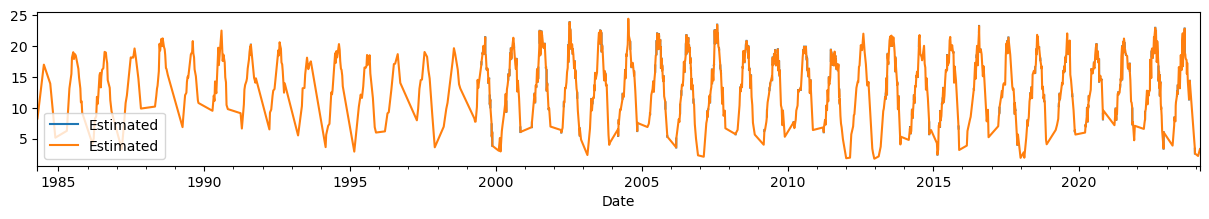

In [31]:
fig, ax = plt.subplots(figsize=(15, 2))
all_data[all_data['Name'] == 'Snake_River_128'].resample('D', on='Date').mean().reset_index().plot(x='Date', y='pred_temp', ax=ax, label='Estimated', #s=1 
                                                                                        )
all_data[all_data['Name'] == 'Snake_River_128'].plot(x='Date', y='pred_temp', ax=ax, label='Estimated', #s=1 
                                                                                        )
# ax.set_xlim('2000-01-01', '2023-12-31')

In [32]:
all_data

,Date,Name,RKm,LandTempC,DOY,NDVI,WaterTempC,ClimateClass,WidthMean,avg_temp(C),pred_temp
801,1984-06-10,Akolkolex_River_1,0,15.68870,162,0.666048,11.62170,27.0,850.0,NaN,11.048200
803,1984-07-05,Akolkolex_River_1,0,20.81980,187,0.709074,13.50920,27.0,850.0,NaN,15.150000
804,1984-07-21,Akolkolex_River_1,0,8.30701,203,0.330073,9.61027,27.0,850.0,NaN,15.982300
805,1984-07-28,Akolkolex_River_1,0,18.92770,210,0.689432,8.23007,27.0,850.0,NaN,17.775900
806,1984-08-06,Akolkolex_River_1,0,17.45520,219,0.637802,15.75300,27.0,850.0,NaN,17.009200
...,...,...,...,...,...,...,...,...,...,...,...
1290866,2022-01-24,Youngs_River_5,40,6.41927,24,0.875998,5.93642,9.0,15.0,NaN,6.881000
1290886,2022-11-24,Youngs_River_5,40,10.26490,328,0.884728,10.05860,9.0,15.0,NaN,8.476000
1290295,2023-09-28,Youngs_River_5,40,-1.11328,271,0.165216,2.42612,9.0,15.0,NaN,14.623333
1290905,2023-11-27,Youngs_River_5,40,6.92132,331,0.876755,6.69522,9.0,15.0,NaN,6.864000


In [33]:
lsat_data = pd.read_csv(landsat_data_fn, parse_dates=['Date'])

In [34]:
lsat_data[lsat_data['Mission']=='L5']['Name'].unique()

array(['Akolkolex_River_1', 'Akolkolex_River_2', 'Akolkolex_River_3', ...,
       'Youngs_River_3', 'Youngs_River_4', 'Youngs_River_5'], dtype=object)